# Get around

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
dataset = pd.read_excel(
    "https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx"
)

In [4]:
dataset.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


### Data cleaning

In [6]:
# Filter dataset to have not null delay_at_checkout_in_minutes for every ended state

dataset_clean = dataset[
            (dataset['state']=='canceled') & (dataset["delay_at_checkout_in_minutes"].isnull()) |
            ((dataset["state"] == "ended") & (dataset["delay_at_checkout_in_minutes"].notnull()))
        ].reset_index(drop=True)

# Keep the cancelled state
dataset_clean_canceled = dataset_clean[(dataset_clean["state"] == "canceled")]

# Remove outliers from dataset. We assume that people can't have delay for more that one 3 days.
dataset_clean = dataset_clean[
    (dataset_clean["delay_at_checkout_in_minutes"] <= 60 * 24 * 3)
    & (dataset_clean["delay_at_checkout_in_minutes"] >= -60 * 24 * 3)
]

dataset_clean = pd.concat([dataset_clean, dataset_clean_canceled])


Which share of our owner’s revenue would potentially be affected by the feature?

<Axes: ylabel='proportion'>

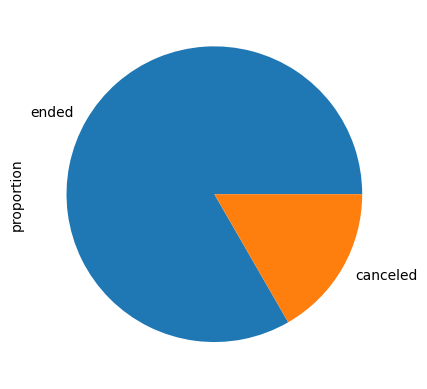

In [7]:
### What are the proportion of cancellation 
dataset_clean["state"].value_counts(normalize=True).plot(kind="pie")

In [57]:
dataset_clean["checkin_type"].value_counts()

checkin_type
mobile     15372
connect     4200
Name: count, dtype: int64

In [9]:
dataset_clean["state"].value_counts(normalize=True)

state
ended       0.833231
canceled    0.166769
Name: proportion, dtype: float64

In [10]:
cancelation_rate = dataset_clean["state"].value_counts(normalize=True).iloc[1]*100

print(
    f"We can see that there is almost {cancelation_rate.round(2)}% of cancellation"
)

We can see that there is almost 16.68% of cancellation


Let's check the proportion of cancellation due the late of the previous rental

In [11]:
cancel_previous = dataset_clean[
    (dataset_clean["state"] == "canceled")
    & (dataset_clean["time_delta_with_previous_rental_in_minutes"].notna())
]

In [12]:
long_late = (
    len(cancel_previous["previous_ended_rental_id"])
    - len(cancel_previous["previous_ended_rental_id"].unique())
)

In [13]:
canceled_previous_dt = dataset_clean[
    (
        dataset_clean["rental_id"].isin(
            cancel_previous["previous_ended_rental_id"].unique()
        )
    )
    & (dataset_clean["delay_at_checkout_in_minutes"].notna())
][["checkin_type" ,"delay_at_checkout_in_minutes"]]

In [14]:
cancelation_late = (len(canceled_previous_dt[canceled_previous_dt["delay_at_checkout_in_minutes"] > 0]) + long_late)*100 // len(canceled_previous_dt)
print(f"We can see that {cancelation_late}% of the rental cancelation is due to late checkout")

We can see that 60% of the rental cancelation is due to late checkout


In [15]:
affected_owner_share = cancelation_rate * cancelation_late/100

In [16]:
affected_owner_share

np.float64(10.006131207847945)

How many rentals would be affected by the feature depending on the threshold and scope we choose?

In [17]:
# Let's check the average delay_at_checkout_in_minutes by checking_type
dataset_clean.groupby("checkin_type")["delay_at_checkout_in_minutes"].mean()

checkin_type
connect   -43.627278
mobile     59.280490
Name: delay_at_checkout_in_minutes, dtype: float64

In average: the connected checking type more than 40 min on time where mobile checking type have almost 1h hour late

In [9]:
# Create new column late range of chechout time with modality early, 15min, 30min , 1h , 2h, 4h, more than 4h on the dataset_clean dateframe
categories = ["early", "on time", "15min", "30min", "1h", "2h", "4h", "more than 4h"]
dataset_clean["late_range_checkout_time"] = pd.cut(
    dataset_clean["delay_at_checkout_in_minutes"],
    bins=[-np.inf, 0, 15, 30, 60, 120, 240, 480, np.inf],
    labels=categories,
)
dataset_clean["late_range_checkout_time"] = pd.Categorical(
    dataset_clean["late_range_checkout_time"], categories=categories, ordered=True
)

In [36]:
connect_pro = (dataset_clean["late_range_checkout_time"][
    dataset_clean["checkin_type"] == "connect"
].value_counts(normalize=True).sort_index() *100).reset_index()

mobile_pro = (dataset_clean["late_range_checkout_time"][
    dataset_clean["checkin_type"] == "mobile"
].value_counts(normalize=True).sort_index() *100).reset_index()

In [ ]:
# create a column cumulative_proportion base on column the column proportion in connect_pro dataframe
connect_pro["cumulative_proportion_connect"] = connect_pro["proportion"].cumsum()
mobile_pro["cumulative_proportion_mobile"] = mobile_pro["proportion"].cumsum()

In [48]:
# Join connect_pro, mobile_pro dataframes on late_range_checkout_time
cumMobCon = connect_pro.drop(columns=["proportion"]).merge(
    mobile_pro.drop(columns=["proportion"]), on="late_range_checkout_time"
)

In [67]:
cumMobCon_long

,late_range_checkout_time,Type,Proportion
0,early,Connect,57.113463
1,on time,Connect,67.372134
2,15min,Connect,74.191652
3,30min,Connect,83.744856
4,1h,Connect,92.328042
5,2h,Connect,97.442681
6,4h,Connect,99.353322
7,more than 4h,Connect,100.000000
8,early,Mobile,38.687432
9,on time,Mobile,51.386952


In [75]:
# Convertir le DataFrame au format "long" pour Plotly Express
cumMobCon_long = cumMobCon.melt(
    id_vars=["late_range_checkout_time"],
    value_vars=[
        "cumulative_proportion_connect",
        "cumulative_proportion_mobile",
    ],
    var_name="Type",
    value_name="Proportion")

# Remplacer les noms dans la colonne "Type" par les labels souhaités
cumMobCon_long["Type"] = cumMobCon_long["Type"].replace(
    {
        "cumulative_proportion_connect": "Connect",
        "cumulative_proportion_mobile": "Mobile",
    }
)

# Créer le graphique avec les nouvelles données
fig = px.bar(
    cumMobCon_long,
    x="late_range_checkout_time",
    y="Proportion",
    color="Type", 
    title="Cumulative Proportion of Mobile and Connect Check-ins by Late Range of Checkout Time",
    color_discrete_sequence=px.colors.sequential.Turbo,
    height=500, width=800
)

fig.update_layout(
    barmode="group",
    xaxis_title="Late Range of Checkout Time",
    yaxis_title="Cumulative Proportion",
    yaxis=dict(
        tickmode="linear",  # Mode pour un espacement constant
        dtick=10,  # Espacement des ticks (10 unités)
    ),
)
fig.show()

/home/triomphant/.local/lib/python3.12/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [20]:
dataset_clean["checkin_type"] = pd.Categorical(
    dataset_clean["checkin_type"], categories=["mobile", "connect"], ordered=True
)

In [21]:
def calculate_impact_cases(df, thresholds=range(10, 240, 20)):
    # Initialiser les listes pour stocker les résultats
    mobile_cases = []
    connect_cases = []

    # Filtrer pour les retards positifs
    delay_df = df[df["delay_at_checkout_in_minutes"] > 0]

    # Boucle à travers les seuils de retard pour calculer les impacts
    for i in thresholds:
        mob_count, conn_count = (
            delay_df[delay_df["delay_at_checkout_in_minutes"] <= i]["checkin_type"]
            .value_counts()
            .reindex(["mobile", "connect"], fill_value=0)
        )
        mobile_cases.append(mob_count)
        connect_cases.append(conn_count)

    # Créer le DataFrame des résultats
    impact_df = pd.DataFrame(
        {
            "threshold": thresholds,
            "mobile_case": mobile_cases,
            "connect_case": connect_cases,
        }
    )

    return impact_df

In [22]:
impact_df = calculate_impact_cases(dataset_clean)

<Axes: xlabel='threshold'>

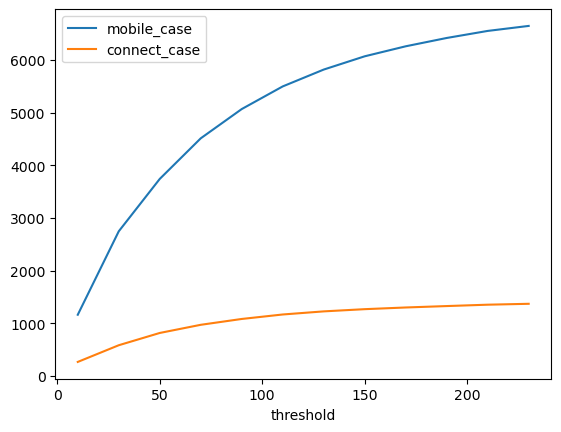

In [23]:
impact_df.plot(kind="line", x="threshold")

How often are drivers late for the next check-in? How does it impact the next driver?

In [24]:
nextcheckin_late_df = dataset_clean[dataset_clean["state"] == "ended"][["delay_at_checkout_in_minutes"]]
nextcheckin_late_pro = ((nextcheckin_late_df > 0).sum()).iloc[0] * 100  // len(nextcheckin_late_df)
nextcheckin_late_avg = nextcheckin_late_df[nextcheckin_late_df["delay_at_checkout_in_minutes"] > 0].mean().values[0].round(2)
print(
    f"The drivers are late {nextcheckin_late_pro}% of the time. This can lead to make the next driver to wait for {nextcheckin_late_avg} minutes in average"
)

The drivers are late 57% of the time. This can lead to make the next driver to wait for 156.84 minutes in average


* How many problematic cases will it solve depending on the chosen threshold and scope?

In [25]:
solve_df = calculate_impact_cases(canceled_previous_dt)

<Axes: xlabel='threshold'>

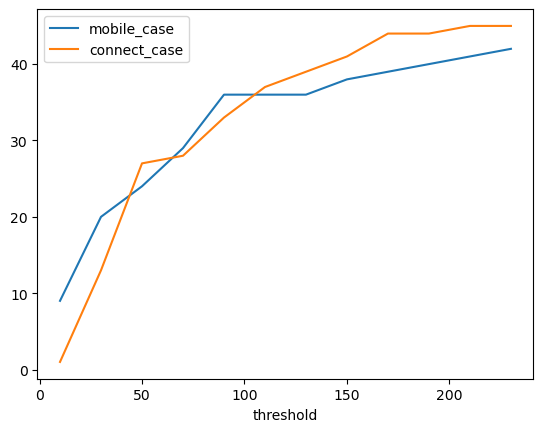

In [26]:
solve_df.plot(kind="line", x="threshold")

In [27]:
distinct_car = len(dataset_clean["car_id"].unique())
print(f'We have {distinct_car} distinct cars in the dataset')

We have 7485 distinct cars in the dataset


In [28]:
def get_top_cars_with_late_checkouts(dataset_clean, top_n=30):
    # Compte le nombre d'occurrences de chaque voiture
    car_usage_count = dataset_clean["car_id"].value_counts()

    # Filtre pour ne garder que les voitures utilisées plus d'une fois
    frequently_used_cars = car_usage_count[car_usage_count > 1]

    # Sélectionne les top_n voitures les plus fréquemment utilisées
    top_used_cars_df = dataset_clean[
        dataset_clean["car_id"].isin(frequently_used_cars.index[:top_n])
    ][["car_id", "checkin_type", "delay_at_checkout_in_minutes"]]

    # Marque comme "is_late" si le retard est négatif
    top_used_cars_df["is_late"] = top_used_cars_df[
        "delay_at_checkout_in_minutes"
    ].apply(lambda x: 1 if x > 0 else 0)

    # Ajoute une colonne 'count' pour compter chaque entrée
    top_used_cars_df["count"] = 1

    # Calcule la moyenne de retard pour chaque voiture
    late_mean_per_car = (
        top_used_cars_df[top_used_cars_df["is_late"] == 1]
        .groupby("car_id")["delay_at_checkout_in_minutes"]
        .mean()
    ).rename("mean_delay")

    # Calcule le nombre de retards et le nombre total d'utilisations pour chaque voiture
    late_rate_per_car = top_used_cars_df.groupby("car_id")[["is_late", "count"]].sum()

    # Calcule le taux de retard pour chaque voiture
    late_rate_per_car["late_rate"] = (
        late_rate_per_car["is_late"] * 100 / late_rate_per_car["count"]
    )

    # Combine la moyenne de retard et le taux de retard
    result = pd.concat([late_mean_per_car, late_rate_per_car], axis=1)

    # Trie les résultats par taux de retard en ordre décroissant
    return result.sort_values(by="late_rate", ascending=False)

In [29]:
get_top_cars_with_late_checkouts(dataset_clean, 15)

,mean_delay,is_late,count,late_rate
car_id,,,,
350149,239.200000,15,21,71.428571
342699,75.166667,12,26,46.153846
335276,85.333333,9,23,39.130435
365926,129.375000,8,22,36.363636
356106,235.142857,7,20,35.000000
366164,51.714286,7,20,35.000000
300505,34.500000,8,23,34.782609
334190,72.181818,11,33,33.333333
241021,89.222222,9,29,31.034483


- Is there any relation beetween the car and the late checkouts ?

- The car_id 265239 appear twice with different checking type

In [3]:
dataset2 = pd.read_csv(
    "https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_pricing_project.csv", index_col=[0]
)

In [4]:
dataset2.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [36]:
avg_rental_price = dataset2["rental_price_per_day"].mean()

In [37]:
cancel_len = len(dataset_clean[dataset_clean['state'] == "canceled"])

In [40]:
print(
    f"From the previous analysis we know that 60% of the cancellations are due to late. Then fixing the late problem can increase the profit for more than {(cancelation_late/100 * cancel_len * avg_rental_price).round(2)} and increase the they reliability"
)

From the previous analysis we know that 60% of the cancellations are due to late. Then fixing the late problem can increase the profit for more than 237386.55
